In [31]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn

import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import glob
import os
# from tensorflow.keras.models import load_model

# from tensorflow.keras.models import Model
import os
import warnings


from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn



In [32]:
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore DeprecationWarnings
warnings.filterwarnings("ignore", category=FutureWarning) 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Running on device: {}'.format(device))

Running on device: cuda


In [33]:

class CustomDataset(Dataset):
    def __init__(self, csv_file, get_pairs, num_pairs = None, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.gender_mapping = {'male': 0, 'female': 1}
        self.ethnicity_mapping = {'white': 0, 'black': 1, 'asian': 2, 'hispanic': 3}
        self.data['nameNum'] = self.data['name'].astype('category').cat.codes
        self.data['nameNum'] = self.data['nameNum'].astype(int)
        self.get_pairs = get_pairs
        self.num_pairs = num_pairs


    def __len__(self):
        return len(self.data)


    
    def getAgeLabel(self,value1):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        if(class_ranges[0][0]<=value1 and value1<class_ranges[0][1]):
            return 0
        elif(class_ranges[1][0]<=value1 and value1<class_ranges[1][1]):
            return 1
        elif(class_ranges[2][0]<=value1 and value1<class_ranges[2][1]):
            return 2
        elif(class_ranges[3][0]<=value1 and value1<class_ranges[3][1]):
            return 3
        else:
            return 0
   

    def __getitem__(self, idx):
        if self.get_pairs == False:
            row = self.data.iloc[idx]
            image_path = '/home/csgrad/byalavar/FHE/celebSet/CELEBTEST/CELEBTEST/'+row['name']+'/' + row['filename']  # Assuming images are in a folder named 'images'
            
            try:
                image = Image.open(image_path)
            except Exception as e:
                # Handle the error, for example, you can return a placeholder image
                print("here")
                #self.__getitem__(idx + 1)
                #image = Image.new('RGB', (224, 224))  # Create a blank image
            
            image = Image.open(image_path)
            age = row['age']
            
            if(row['age']<=0):
                age=35
            label = {
                'age': self.getAgeLabel(age),
                'gender': self.gender_mapping.get(row['gender'], 0),  # -1 for unknown
                'ethnicity': self.ethnicity_mapping.get(row['ethnicity'], 0),
                'age1':age,
                'name' : row['nameNum']
            
            }
            #print(row['name'])
            if self.transform:
                image = self.transform(image)

            return image, label

        # else
        else:
            if self.num_pairs == None:
                print("Num of Pairs not specified.Setting to 50.")
                self.num_pairs = 50
            row = self.data.iloc[idx]
            image_path = '/home/csgrad/byalavar/FHE/celebSet/CELEBTEST/CELEBTEST/'+row['name']+'/' + row['filename']  # Assuming images are in a folder named 'images'
            
            try:
                image = Image.open(image_path)
            except Exception as e:
                # Handle the error, for example, you can return a placeholder image
                print("here")
                #self.__getitem__(idx + 1)
                #image = Image.new('RGB', (224, 224))  # Create a blank image
            
            image = Image.open(image_path)
            
            #print(row['name'])
            if self.transform:
                image = self.transform(image)

            genuine_images = []
            imposter_images = []
            if idx + self.num_pairs < len(self.data):
                if idx - self.num_pairs >= 0:
                    st = idx - self.num_pairs
                else:
                    st = 0
                end = idx + self.num_pairs
            else:
                st = idx - self.num_pairs + 1
                end = idx + 1
            for i in range(st, end):
                row_pair = self.data.iloc[i]
                
                if row_pair['nameNum'] == row['nameNum']:

                    image_path_pair = '/home/csgrad/byalavar/FHE/celebSet/CELEBTEST/CELEBTEST/' + row_pair['name'] + '/' + row_pair['filename']

                    image_pair = Image.open(image_path_pair)
                    #print(row['name'])
                    if self.transform:
                        image_pair = self.transform(image_pair)

                    
                    genuine_images.append(image_pair)
                if len(genuine_images) == self.num_pairs:
                    break
                
            i = idx
            while True:
                i = (i + 1000) % len(self.data)
                row_pair = self.data.iloc[i]
                
                if row_pair['nameNum'] != row['nameNum']:

                    image_path_pair = '/home/csgrad/byalavar/FHE/celebSet/CELEBTEST/CELEBTEST/' + row_pair['name'] + '/' + row_pair['filename']

                    image_pair = Image.open(image_path_pair)
                    #print(row['name'])
                    if self.transform:
                        image_pair = self.transform(image_pair)

                    
                    imposter_images.append(image_pair)
                if len(imposter_images) == self.num_pairs:
                    break
            # print(images)
            # print(len(genuine_images))
            # print(len(imposter_images))
            return image, genuine_images, imposter_images



In [34]:
# csv_file = '/home/csgrad/byalavar/FHE/celebSet/celebSET_final_v1.csv'  # Replace with the actual path to your CSV file
# df = pd.read_csv(csv_file)

# # Create a list to store the indices of rows with missing files
# rows_to_remove = []
# count=0
# # Iterate through the DataFrame and check if the files exist
# for index, row in df.iterrows():
#     image_path = '/home/csgrad/byalavar/FHE/celebSet/CELEBTEST/CELEBTEST/'+row['name']+'/' + row['filename'] 
#     if not os.path.exists(image_path):
#         rows_to_remove.append(index)
#         count=count+1
# df = df.drop(rows_to_remove)
# df.to_csv(csv_file, index=False)
# print(count)

In [35]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Resize the image to the desired size
    transforms.ToTensor(),          # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


In [36]:
trainSet = CustomDataset('/home/csgrad/byalavar/FHE/celebSet/celebSET_final_v1.csv', get_pairs=True, num_pairs= 10, transform=transform)
trainloader = DataLoader(trainSet, batch_size=16, shuffle=True, num_workers=2)

testSet = CustomDataset('/home/csgrad/byalavar/FHE/celebSet/final_clebSET_test.csv', get_pairs=True, num_pairs= 10, transform=transform)
testloader = DataLoader(testSet, batch_size=16, shuffle=False, num_workers=2)


In [37]:
trainSet.__len__()

70889

In [38]:
def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


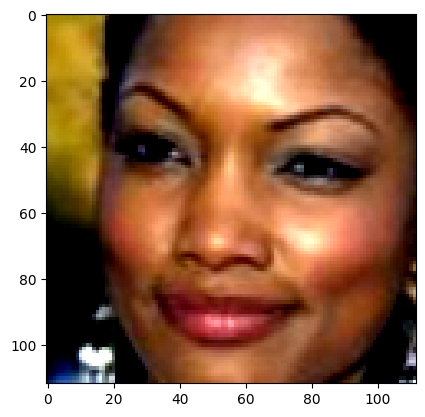

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


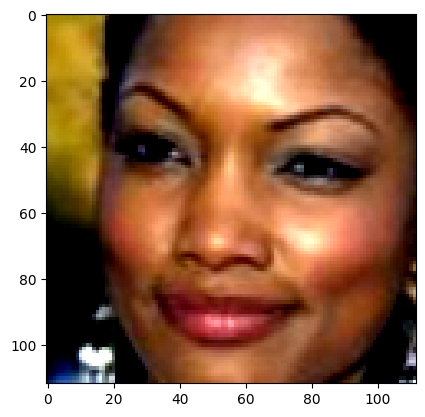

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


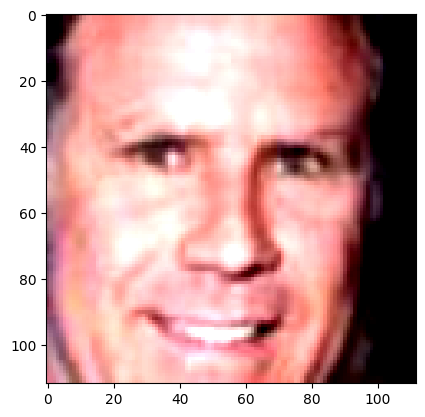

In [39]:
tempIter = iter(testloader)
images,gen_pairs, imp_pairs = next(tempIter)
# imshow(images[0])
# print(labels['age'][0],labels['gender'][0],labels['ethnicity'][0])
# print(image_pairs)
imshow(images[0])
imshow(gen_pairs[0][0])
imshow(imp_pairs[0][0])

In [40]:
from collections import namedtuple
import torch
import torch.nn as nn
from torch.nn import Dropout
from torch.nn import MaxPool2d
from torch.nn import Sequential
from torch.nn import Conv2d, Linear
from torch.nn import BatchNorm1d, BatchNorm2d
from torch.nn import ReLU, Sigmoid
from torch.nn import Module
from torch.nn import PReLU
import os

def build_model(model_name='ir_50'):
    if model_name == 'ir_101':
        return IR_101(input_size=(112,112))
    elif model_name == 'ir_50':
        return IR_50(input_size=(112,112))
    elif model_name == 'ir_se_50':
        return IR_SE_50(input_size=(112,112))
    elif model_name == 'ir_34':
        return IR_34(input_size=(112,112))
    elif model_name == 'ir_18':
        return IR_18(input_size=(112,112))
    else:
        raise ValueError('not a correct model name', model_name)

def initialize_weights(modules):
    """ Weight initilize, conv2d and linear is initialized with kaiming_normal
    """
    for m in modules:
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight,
                                    mode='fan_out',
                                    nonlinearity='relu')
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight,
                                    mode='fan_out',
                                    nonlinearity='relu')
            if m.bias is not None:
                m.bias.data.zero_()


class Flatten(Module):
    """ Flat tensor
    """
    def forward(self, input):
        return input.view(input.size(0), -1)


class LinearBlock(Module):
    """ Convolution block without no-linear activation layer
    """
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(LinearBlock, self).__init__()
        self.conv = Conv2d(in_c, out_c, kernel, stride, padding, groups=groups, bias=False)
        self.bn = BatchNorm2d(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class GNAP(Module):
    """ Global Norm-Aware Pooling block
    """
    def __init__(self, in_c):
        super(GNAP, self).__init__()
        self.bn1 = BatchNorm2d(in_c, affine=False)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.bn2 = BatchNorm1d(in_c, affine=False)

    def forward(self, x):
        x = self.bn1(x)
        x_norm = torch.norm(x, 2, 1, True)
        x_norm_mean = torch.mean(x_norm)
        weight = x_norm_mean / x_norm
        x = x * weight
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        feature = self.bn2(x)
        return feature


class GDC(Module):
    """ Global Depthwise Convolution block
    """
    def __init__(self, in_c, embedding_size):
        super(GDC, self).__init__()
        self.conv_6_dw = LinearBlock(in_c, in_c,
                                     groups=in_c,
                                     kernel=(7, 7),
                                     stride=(1, 1),
                                     padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(in_c, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size, affine=False)

    def forward(self, x):
        x = self.conv_6_dw(x)
        x = self.conv_6_flatten(x)
        x = self.linear(x)
        x = self.bn(x)
        return x


class SEModule(Module):
    """ SE block
    """
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = Conv2d(channels, channels // reduction,
                          kernel_size=1, padding=0, bias=False)

        nn.init.xavier_uniform_(self.fc1.weight.data)

        self.relu = ReLU(inplace=True)
        self.fc2 = Conv2d(channels // reduction, channels,
                          kernel_size=1, padding=0, bias=False)

        self.sigmoid = Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return module_input * x



class BasicBlockIR(Module):
    """ BasicBlock for IRNet
    """
    def __init__(self, in_channel, depth, stride):
        super(BasicBlockIR, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride, bias=False),
                BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
            BatchNorm2d(depth),
            PReLU(depth),
            Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
            BatchNorm2d(depth))

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)

        return res + shortcut


class BottleneckIR(Module):
    """ BasicBlock with bottleneck for IRNet
    """
    def __init__(self, in_channel, depth, stride):
        super(BottleneckIR, self).__init__()
        reduction_channel = depth // 4
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride, bias=False),
                BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, reduction_channel, (1, 1), (1, 1), 0, bias=False),
            BatchNorm2d(reduction_channel),
            PReLU(reduction_channel),
            Conv2d(reduction_channel, reduction_channel, (3, 3), (1, 1), 1, bias=False),
            BatchNorm2d(reduction_channel),
            PReLU(reduction_channel),
            Conv2d(reduction_channel, depth, (1, 1), stride, 0, bias=False),
            BatchNorm2d(depth))

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)

        return res + shortcut


class BasicBlockIRSE(BasicBlockIR):
    def __init__(self, in_channel, depth, stride):
        super(BasicBlockIRSE, self).__init__(in_channel, depth, stride)
        self.res_layer.add_module("se_block", SEModule(depth, 16))


class BottleneckIRSE(BottleneckIR):
    def __init__(self, in_channel, depth, stride):
        super(BottleneckIRSE, self).__init__(in_channel, depth, stride)
        self.res_layer.add_module("se_block", SEModule(depth, 16))


class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
    '''A named tuple describing a ResNet block.'''


def get_block(in_channel, depth, num_units, stride=2):

    return [Bottleneck(in_channel, depth, stride)] +\
           [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
    if num_layers == 18:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=2),
            get_block(in_channel=64, depth=128, num_units=2),
            get_block(in_channel=128, depth=256, num_units=2),
            get_block(in_channel=256, depth=512, num_units=2)
        ]
    elif num_layers == 34:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=6),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 50:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=14),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 100:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=13),
            get_block(in_channel=128, depth=256, num_units=30),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 152:
        blocks = [
            get_block(in_channel=64, depth=256, num_units=3),
            get_block(in_channel=256, depth=512, num_units=8),
            get_block(in_channel=512, depth=1024, num_units=36),
            get_block(in_channel=1024, depth=2048, num_units=3)
        ]
    elif num_layers == 200:
        blocks = [
            get_block(in_channel=64, depth=256, num_units=3),
            get_block(in_channel=256, depth=512, num_units=24),
            get_block(in_channel=512, depth=1024, num_units=36),
            get_block(in_channel=1024, depth=2048, num_units=3)
        ]

    return blocks


class Backbone(Module):
    def __init__(self, input_size, num_layers, mode='ir'):
        """ Args:
            input_size: input_size of backbone
            num_layers: num_layers of backbone
            mode: support ir or irse
        """
        super(Backbone, self).__init__()
        assert input_size[0] in [112, 224], \
            "input_size should be [112, 112] or [224, 224]"
        assert num_layers in [18, 34, 50, 100, 152, 200], \
            "num_layers should be 18, 34, 50, 100 or 152"
        assert mode in ['ir', 'ir_se'], \
            "mode should be ir or ir_se"
        self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1, bias=False),
                                      BatchNorm2d(64), PReLU(64))
        blocks = get_blocks(num_layers)
        if num_layers <= 100:
            if mode == 'ir':
                unit_module = BasicBlockIR
            elif mode == 'ir_se':
                unit_module = BasicBlockIRSE
            output_channel = 512
        else:
            if mode == 'ir':
                unit_module = BottleneckIR
            elif mode == 'ir_se':
                unit_module = BottleneckIRSE
            output_channel = 2048

        if input_size[0] == 112:
            self.output_layer = Sequential(BatchNorm2d(output_channel),
                                        Dropout(0.4), Flatten(),
                                        Linear(output_channel * 7 * 7, 512),
                                        BatchNorm1d(512, affine=False))
        else:
            self.output_layer = Sequential(
                BatchNorm2d(output_channel), Dropout(0.4), Flatten(),
                Linear(output_channel * 14 * 14, 512),
                BatchNorm1d(512, affine=False))

        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(
                    unit_module(bottleneck.in_channel, bottleneck.depth,
                                bottleneck.stride))
        self.body = Sequential(*modules)

        initialize_weights(self.modules())


    def forward(self, x):
        
        # current code only supports one extra image
        # it comes with a extra dimension for number of extra image. We will just squeeze it out for now
        x = self.input_layer(x)

        for idx, module in enumerate(self.body):
            x = module(x)

        x = self.output_layer(x)
        norm = torch.norm(x, 2, 1, True)
        output = torch.div(x, norm)

        return output, norm



def IR_18(input_size):
    """ Constructs a ir-18 model.
    """
    model = Backbone(input_size, 18, 'ir')

    return model


def IR_34(input_size):
    """ Constructs a ir-34 model.
    """
    model = Backbone(input_size, 34, 'ir')

    return model


def IR_50(input_size):
    """ Constructs a ir-50 model.
    """
    model = Backbone(input_size, 50, 'ir')

    return model


def IR_101(input_size):
    """ Constructs a ir-101 model.
    """
    model = Backbone(input_size, 100, 'ir')

    return model


def IR_152(input_size):
    """ Constructs a ir-152 model.
    """
    model = Backbone(input_size, 152, 'ir')

    return model


def IR_200(input_size):
    """ Constructs a ir-200 model.
    """
    model = Backbone(input_size, 200, 'ir')

    return model


def IR_SE_50(input_size):
    """ Constructs a ir_se-50 model.
    """
    model = Backbone(input_size, 50, 'ir_se')

    return model


def IR_SE_101(input_size):
    """ Constructs a ir_se-101 model.
    """
    model = Backbone(input_size, 100, 'ir_se')

    return model


def IR_SE_152(input_size):
    """ Constructs a ir_se-152 model.
    """
    model = Backbone(input_size, 152, 'ir_se')

    return model


def IR_SE_200(input_size):
    """ Constructs a ir_se-200 model.
    """
    model = Backbone(input_size, 200, 'ir_se')

    return model


adaface_models = {
    'ir_18':"/home/csgrad/byalavar/FHE/HEAAN/FA_CVPR_Exp/adaface_ir18_webface4m.ckpt",
}


def load_pretrained_model(architecture='ir_18'):
    # load model and pretrained statedict
    assert architecture in adaface_models.keys()
    model = build_model(architecture)
    statedict = torch.load(adaface_models[architecture])['state_dict']
    model_statedict = {key[6:]:val for key, val in statedict.items() if key.startswith('model.')}
    model.load_state_dict(model_statedict)
    model.eval()
    return model

def to_input(pil_rgb_image):
    np_img = np.array(pil_rgb_image)
    brg_img = ((np_img[:,:,::-1] / 255.) - 0.5) / 0.5
    tensor = torch.tensor([brg_img.transpose(2,0,1)]).float()
    return tensor

In [41]:
adaFaceModel = load_pretrained_model('ir_18')

# print(images.shape)
# bgr_image = images[:, [2, 1, 0], :, :]
# print(bgr_image.shape)


#feature, _ = adaFaceModel(bgr_image)

In [42]:
# adaFaceModel.to(device)
# adaFaceModel.eval()

# csv_file = '/home/csgrad/byalavar/FHE/celebSet/celebSET_final_v1.csv'  # Replace with the actual path to your CSV file
# df = pd.read_csv(csv_file)

# image_embeddings = []
# for index, row in df.iterrows():
#     image_path = '/home/csgrad/byalavar/FHE/celebSet/CELEBTEST/CELEBTEST/'+row['name']+'/' + row['filename']  # Assuming images are in a folder named 'images'
            
#     try:
#         image = Image.open(image_path)
#     except Exception as e:
#         # Handle the error, for example, you can return a placeholder image
#         print("here")
    
#     image = Image.open(image_path)
    
#     image = transform(image)
#     image = image.to(device=device)
#     input = image[[2, 1, 0], :, :]
#     input = input.unsqueeze(0)
#     # print(input.shape)
#     embeddings,_ = adaFaceModel(input)
#     image_embeddings.append(embeddings)
    
    

In [43]:
trainSet.data['age'].min()

-9

In [44]:
def get_normalized_age_value(original_age_value):
    return (original_age_value - trainSet.data['age'].min())/(trainSet.data['age'].max() - trainSet.data['age'].min())


def get_original_age_value(normalized_age_value):
    return normalized_age_value * (trainSet.data['age'].max()  - trainSet.data['age'].min()) + trainSet.data['age'].min()

In [45]:
from torch.nn.modules import MSELoss
from torch.nn.modules.loss import CrossEntropyLoss
from torch.nn.parallel import DataParallel
import torch.multiprocessing as mp

class CompressionModel(nn.Module):
    def __init__(self, input_dim, compressed_dim):
        super(CompressionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, compressed_dim),
            nn.ReLU()
        )
        # self.linear = nn.Linear(compressed_dim, 1030)

    def forward(self, x):
        encoded = self.encoder(x)
        # y = self.linear(encoded)
        # y = F.softmax(y, dim = 0)
        return encoded

class CompressionLoss(nn.Module):
    def __init__(self):
        super(CompressionLoss, self).__init__()

    def forward(self, img, genuine_imgs, imposter_imgs, genuine_sim, imposter_sim):
        
        # 
        # Compute cosine similarity loss
        genuine_loss = 0
        for i in range(len(genuine_imgs)):
            sim_score = F.cosine_similarity(img, genuine_imgs[i])
        # print(true_sim.view(-1).shape)
            genuine_loss += torch.mean(torch.abs(sim_score - genuine_sim[i].view(-1)))

        imp_loss = 0
        for i in range(len(imposter_imgs)):
            imp_sim_score = F.cosine_similarity(img, imposter_imgs[i])
        # print(true_sim.view(-1).shape)
            imp_loss += torch.mean(torch.abs(imp_sim_score - imposter_sim[i].view(-1)))
        # print(loss)

        
        matrix = torch.cat([genuine_imgs[0], imposter_imgs[0]], dim=0)

        for i in range(1, len(genuine_imgs)):
            matrix = torch.cat([matrix, genuine_imgs[i]], dim = 0)
            matrix = torch.cat([matrix, imposter_imgs[i]], dim = 0)

        mean_matrix = torch.mean(matrix, dim = 0)
        # matrix = matrix.view(matrix.shape[0]*matrix.shape[1], matrix.shape[2])
        mx = torch.matmul(mean_matrix.t(), mean_matrix)
        vx = torch.matmul(matrix.t(), matrix) / 16.0
        cov_matrix = mx - vx
        diag = torch.diag(cov_matrix.diag())
        cov_loss = torch.mean(torch.abs(cov_matrix - diag))

        g_dist = torch.cat([genuine_imgs[0], genuine_imgs[1]], dim = 0)
        for i in range(2, len(genuine_imgs)):
            g_dist = torch.cat([g_dist, genuine_imgs[i]], dim = 0)

        imp_dist = torch.cat([imposter_imgs[0], imposter_imgs[1]], dim = 0)
        for i in range(2, len(imposter_imgs)):
            imp_dist = torch.cat([imp_dist, imposter_imgs[i]], dim = 0)

        gloss = (torch.mean(g_dist) + 1.0) * 0.5
        iloss = (torch.mean(imp_dist) + 1.0) * 0.5

        lda_term = iloss / gloss
        return genuine_loss + imp_loss + 10 * cov_loss 


In [52]:

class faceAnalytics(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.layer1=nn.Linear(128,64)
        self.dropout1=nn.Dropout(0.2)
        self.layer2=nn.Linear(64,32)
        #self.layer3=nn.Linear(1024,512)
        # self.layer4=nn.Linear(128,64)
        self.dropout2=nn.Dropout(0.2)
        self.genderOut=nn.Linear(32,2)
        self.ageOut=nn.Linear(32,4)
        self.ethnicityOut = nn.Linear(32,2)
        self.identity = nn.Sequential(nn.Linear(32,64), nn.ReLU(), nn.Linear(64,80))
        # self.maxVal = 0
        # self.min=0
        
    
    def writeResult(self,result):
       output_directory=""
       file_name = "resultAge.txt"

       with open(os.path.join(output_directory, file_name), "w") as file:
        for value in result:
            file.write(f"{value}\n")
    
    def forward(self,x):

        #print("Input",x[0])
        x=self.layer1(x)
        #print(x[0])
        #x=nn.functional.relu(x)
        #x=self.dropout1(x)
        #x=nn.functional.relu(x)
        x=self.layer2(x)
        
        #self.writeResult(x[0])
       # x=self.layer3(x)
        # x=self.layer4(x)
        #print(torch.max(torch.abs(x)))
        #x=nn.functional.relu(x)
        
        x=self.dropout2(x)
        gender=self.genderOut(x)
        
        age=self.ageOut(x)

        ethn = self.ethnicityOut(x)
        identity = self.identity(x)
        #self.writeResult(age[0])
        #print(gender)
        return gender,age,ethn, identity
    
    
    def are_values_in_same_class(self,value1, value2):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        for class_range in class_ranges:
            if class_range[0] <= value1 < class_range[1] and class_range[0] <= value2 < class_range[1]:
                return True
    
        return False    
    
    def parallelTraining(self, adaFace, model, img, gen_pairs, imp_pairs, criterion, optimizer, cuda_num):
        adaFace = adaFace.to(f'cuda:{cuda_num}')
        img = img.to(f'cuda:{cuda_num}')
        input = img[:, [2, 1, 0], :, :]
        #print(inputs.shape)
        embeddings,_ = adaFace(input)
        compressed_img = model(embeddings)
        gen_sim_scores = []
        gen_embedding_pairs = []
        for img_pair in gen_pairs:

            img_pair = img_pair.to(f'cuda:{cuda_num}')
            input_pair = img_pair[:, [2, 1, 0], :, :]
            #print(inputs.shape)
            embedding_pair, _ = adaFace(input_pair)
            compressed_img2 = model(embedding_pair)
            gen_embedding_pairs.append(compressed_img2)
            sim_score = F.cosine_similarity(embeddings, embedding_pair)
            gen_sim_scores.append(sim_score)
        
        imp_sim_scores = []
        imp_embedding_pairs = []
        for img_pair in imp_pairs:

            img_pair = img_pair.to(f'cuda:{cuda_num}')
            input_pair = img_pair[:, [2, 1, 0], :, :]
            #print(inputs.shape)
            embedding_pair, _ = adaFace(input_pair)
            compressed_img2 = model(embedding_pair)
            imp_embedding_pairs.append(compressed_img2)
            sim_score = F.cosine_similarity(embeddings, embedding_pair)
            imp_sim_scores.append(sim_score)
        
        loss = criterion(compressed_img, gen_embedding_pairs, imp_embedding_pairs, gen_sim_scores, imp_sim_scores)
        loss = loss.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()
    
    def trainCompressionModel(self, trainloader1, trainloader2, trainloader3, trainloader4, testloader, adaFace, compressionModel, compressionLoss, device, episodes):
        input_dim = 512
        compressed_dim = 128
        model = compressionModel
        # Define optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0004)
        criterion = compressionLoss
        # mp.set_start_method('spawn')
        model.train()
        for ep in range(episodes):
            total_loss = 0
            print("Starting " + str(ep))
            cnt = 0
            for batch1, batch2, batch3, batch4 in zip(trainloader1, trainloader2, trainloader3, trainloader4):
                cnt += 1
                img1, gen_pairs1, imp_pairs1 = batch1
                # img1.to('cuda:0')
                # gen_pairs1.to('cuda:0')
                # imp_pairs1.to('cuda:0')

                img2, gen_pairs2, imp_pairs2 = batch2
                img3, gen_pairs3, imp_pairs3 = batch3
                img4, gen_pairs4, imp_pairs4 = batch4
                
                processes = []
                p1 = mp.Process(target = self.parallelTraining, args = (adaFace, model, img1, gen_pairs1, imp_pairs1, criterion, optimizer, 0))
                processes.append(p1)
                p1.start()

                p2 = mp.Process(target = self.parallelTraining, args = (adaFace, model, img2, gen_pairs2, imp_pairs2, criterion, optimizer, 1))
                processes.append(p2)
                p2.start()

                p3 = mp.Process(target = self.parallelTraining, args = (adaFace, model, img3, gen_pairs3, imp_pairs3, criterion, optimizer, 2))
                processes.append(p3)
                p3.start()

                p4 = mp.Process(target = self.parallelTraining, args = (adaFace, model, img4, gen_pairs4, imp_pairs4, criterion, optimizer, 3))
                processes.append(p4)
                p4.start()

                for p in processes:
                    p.join()

                for p in processes:
                    total_loss += p.exitcode    
                # total_loss += self.parallelTraining(adaFace, model, img1, gen_pairs1, imp_pairs1, criterion, optimizer, 0)
                # total_loss += self.parallelTraining(adaFace, model, img2, gen_pairs2, imp_pairs2, criterion, optimizer, 1)
                # total_loss += self.parallelTraining(adaFace, model, img3, gen_pairs3, imp_pairs3, criterion, optimizer, 2)
                # total_loss += self.parallelTraining(adaFace, model, img4, gen_pairs4, imp_pairs4, criterion, optimizer, 3)
                if cnt % 50 == 0:
                    print("Image count = ", cnt)
            if ep % 5 == 0:
                torch.save(model, f'CompressionModel_80k_{ep}.pt')
            print(f"Epoch [{ep + 1}/{episodes}], Loss: {total_loss}")
        torch.save(model, 'CompressionModel_80k.pt')
        print("Training complete!")


    def trainModel(self,trainLoader,testLoader,adaFace, compressionModel, device,episodes):
        self.train()
        #maxVal = 0
        learningRate=0.01
        gender_loss = nn.CrossEntropyLoss() 
        age_loss = nn.CrossEntropyLoss() 
        ethn_loss = nn.CrossEntropyLoss()
        identityLoss = nn.CrossEntropyLoss()
        #optimizer = torch.optim.Adam(self.parameters(), lr=learningRate)
        optimizer = torch.optim.SGD(self.parameters(), lr=learningRate,
        momentum=0.9, weight_decay=5e-5)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=episodes)
        trainingAcc = []
        for e in range(0,episodes):
            total_training_loss =0
            genderAcc=0
            ethnAcc = 0
            ageAcc=0
            identAcc=0
            count=0
            totalGenderLoss=0


            for i,data in enumerate(trainLoader):

                #print(inputs.shape)
                #inputs = inputs.type(torch.double)
                
                #gender_label = data["gender"].to(device=device)
                #race_label = data["race"].to(device=device)
            # print(i)
                inputs = data[0].to(device=device)
                #inputs = inputs.type(torch.double)
                age_label = (data[1]["age"]).to(device=device)
            
                gender_label = data[1]["gender"].to(device=device)
                ethn_label = data[1]["ethnicity"].to(device=device)

                ident_label = data[1]["name"].to(device=device)
                
                #print(torch.max(ethn_label),torch.min(ethn_label))
                #print(torch.max(gender_label),torch.min(gender_label))

                #print(count)
                #print(inputs.shape)
                inputs = inputs[:, [2, 1, 0], :, :]
                #print(inputs.shape)
                embeddings,_ = adaFace(inputs)
                compressedEm = compressionModel(embeddings)
                gender,age,ethn,ident = self(compressedEm)
                # age=torch.squeeze(age)
                # age=age.type(torch.float32)
                #print(age.shape,age_label.shape)
                #print(gender.shape,gender_label.shape)
                # predictedGender = torch.argmax(gender,dim=1)
                # predictedGender = predictedGender.type(torch.float32)
                #print(gender)
                ageLoss = age_loss(age,age_label)
            
                loss = gender_loss(gender,gender_label) + ageLoss + ethn_loss(ethn,ethn_label)  + identityLoss(ident,ident_label)
                #print(gender)
                #print(gender_label)
                #totalGenderLoss = totalGenderLoss + loss.item()
                loss.backward()
                #print("Loss:",loss)
                optimizer.step()
                optimizer.zero_grad()
                #total_training_loss = total_training_loss+loss.item()*512

                predictedGender = torch.argmax(gender,dim=1)
                predictedEthn = torch.argmax(ethn,dim=1)
                predictedAge = torch.argmax(age,dim=1)
                predictedIdent = torch.argmax(ident,dim=1)
                #print(predictedGender)
                #print(gender_label)
                for j in range(0,predictedGender.shape[0]):
                    count=count+1
                    #print(predictedGender[j].item(),gender_label[j])
                    if(predictedGender[j].item()==gender_label[j].item()):
                        genderAcc=genderAcc+1
                
                    if(predictedEthn[j].item()==ethn_label[j].item()):
                        ethnAcc=ethnAcc+1
    
                    if(predictedAge[j].item()==age_label[j].item()):
                        ageAcc=ageAcc+1

                    if(predictedIdent[j].item()==ident_label[j].item()):
                        identAcc=identAcc+1
    
            genderAccuracy =  genderAcc/count
            trainingAcc.append(genderAccuracy)
            print("Gender Accuracy:", genderAccuracy,"Age Acc:", ageAcc/count, " ethnAcc:", ethnAcc/count, "Identity Accuracy:", identAcc/count)
            #print("total training loss:",total_training_loss/16595,"\n")
            #print("\n")
            scheduler.step()
            #print("max observed value: ", maxVal)
            if(e%2==0):
                self.test(testLoader,adaFace, compressionModel, device)
            
        return trainingAcc

    def are_values_in_same_class(self,value1, value2):

    # Define class ranges
        class_ranges = [(15, 22),(22,40),(40,60),(60,80)]
    
    # Check if both values fall into the same class range
        for class_range in class_ranges:
            if class_range[0] <= value1 < class_range[1] and class_range[0] <= value2 < class_range[1]:
                return True
    
        return False

    def test(self,testLoader,adaFace, compressionModel, device):

         self.eval()
         age_loss = nn.L1Loss()

         totalAgeError = 0
         genderAccuracy = 0
         tempAcc=0
         count=0
         totalGenderLoss=0
         maxAge = 0
         minAge = 0
         ageAccuracy = 0
         total_training_loss =0
         tempAcc=0
         count=0
         totalGenderLoss=0

         genderAcc=0
         ethnAcc = 0
         identAcc = 0
        
         for i,data in enumerate(testLoader):

            #print(inputs.shape)
            #inputs = inputs.type(torch.double)
            
            #gender_label = data["gender"].to(device=device)
            #race_label = data["race"].to(device=device)
            
   
            #inputs = inputs.type(torch.double)
            inputs = data[0].to(device=device)
            age_label = data[1]["age"].to(device=device)
            gender_label = data[1]["gender"].to(device=device)
            ethn_label = data[1]["ethnicity"].to(device=device)
            ident_label = data[1]['name'].to(device=device)
            #print(count)
            inputs = inputs[:, [2, 1, 0], :, :]
            embeddings,_ = adaFace(inputs)
            compressedEm = compressionModel(embeddings)
            gender,age,ethn,ident = self(compressedEm)
         

            predictedGender = torch.argmax(gender,dim=1)
            predictedEthn = torch.argmax(ethn,dim=1)
            predictedAge = torch.argmax(age,dim=1)
            predictedIdent = torch.argmax(ident,dim=1)
            #age = get_original_age_value(age)

            for j in range(0,predictedGender.shape[0]):
                count=count+1
                #print(predictedGender[j].item(),gender_label[j])
                if(predictedGender[j].item()==gender_label[j]):
                    genderAcc=genderAcc+1
                if(predictedEthn[j].item()==ethn_label[j]):
                    ethnAcc=ethnAcc+1
                if(predictedAge[j].item()==age_label[j]):
                   ageAccuracy = ageAccuracy +1
                
                if(predictedIdent[j].item()==ident_label[j].item()):
                    identAcc=identAcc+1

         genderAccuracy =  genderAcc/count
         
         print("Test Gender Accuracy:", genderAccuracy,"Test Age Accuracy:", ageAccuracy/count, "Test ethnicity Accuracy:", ethnAcc/count, "Test Identity Accuracy:", identAcc/count)

         return genderAccuracy,totalAgeError

In [53]:
torch.cuda.device_count()

4

In [54]:
FAmodel=faceAnalytics()
compressionModel = CompressionModel(512, 128)
compressionLoss = CompressionLoss()
#model=torch.load("arcFaceCelebSetBase.pt")
FAmodel = nn.DataParallel(FAmodel)
compressionModel = nn.DataParallel(compressionModel)
compressionLoss = nn.DataParallel(compressionLoss)
FAmodel.to(device)
compressionModel.to(device)
compressionLoss.to(device)

adaFaceModel = adaFaceModel.to(device)
adaFaceModel.eval()

Backbone(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (output_layer): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Flatten()
    (3): Linear(in_features=25088, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (body): Sequential(
    (0): BasicBlockIR(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [55]:

print("FAmodel", FAmodel.device_ids)
print("Compmodel", compressionModel.device_ids)
print("CompLoss", compressionLoss.device_ids)

FAmodel [0, 1, 2, 3]
Compmodel [0, 1, 2, 3]
CompLoss [0, 1, 2, 3]


In [56]:
split_size1 = [trainSet.__len__() // 2, trainSet.__len__() - (trainSet.__len__() // 2)]
split_size2 = [split_size1[0] // 2, split_size1[0] - (split_size1[0] // 2)]
split_size3 = [split_size1[1] // 2, split_size1[1] - (split_size1[1] // 2)]

subset1, subset2 = random_split(trainSet, split_size1)
subset11, subset12 = random_split(subset1, split_size2)
subset21, subset22 = random_split(subset2, split_size3)

trainloader1 = DataLoader(subset11, batch_size=16, shuffle=True, num_workers = 2)
trainloader2 = DataLoader(subset12, batch_size=16, shuffle=True, num_workers = 2)
trainloader3 = DataLoader(subset21, batch_size=16, shuffle=True, num_workers = 2)
trainloader4 = DataLoader(subset22, batch_size=16, shuffle=True, num_workers = 2)


In [57]:

FAmodel.module.trainCompressionModel(trainloader1, trainloader2, trainloader3, trainloader4, testloader,adaFaceModel,compressionModel, compressionLoss, device, 10)

RuntimeError: context has already been set

In [ ]:
# FAmodel.trainCompressionModel(trainloader,testloader,adaFaceModel,compressionModel, compressionLoss, device, 10)

In [ ]:
trainSetDet = CustomDataset('/home/csgrad/byalavar/FHE/celebSet/celebSET_final_v1.csv', get_pairs=False, transform=transform)
trainloaderDet = DataLoader(trainSetDet, batch_size=16, shuffle=True, num_workers=2)

testSetDet = CustomDataset('/home/csgrad/byalavar/FHE/celebSet/final_clebSET_test.csv', get_pairs=False, transform=transform)
testloaderDet = DataLoader(testSetDet, batch_size=16, shuffle=False, num_workers=2)


In [ ]:
FAmodel=faceAnalytics()
FAmodel.to(device)
trainingAcc = FAmodel.trainModel(trainloaderDet,testloaderDet,adaFaceModel,compressionModel, device,5)

In [ ]:
FAmodel.test(testloaderDet,adaFaceModel, compressionModel, device)

In [ ]:
torch.save(model,"arcFaceCelebSetBase.pt")

In [ ]:
torch.save(model,"negGenderBaseWiki.pt")

In [ ]:
plt.plot(trainingAcc)

In [ ]:
torch.save(model,"model92.pt")

In [ ]:
count=0
input1=[]
for i,data in enumerate(val_dataloader):
    
    if(count==0):
     inputs=resnet(data["image"].to(device))

 
     input1 = polyprotect(0,inputs[0])

     break
    count=count+1

In [ ]:
input1

In [ ]:
for param in model.parameters():
    print(param.shape)
    print(param[0])
    print(torch.dot(input1,param[1]))
    break 

In [ ]:
input1

In [ ]:
output_directory=""
file_name = "input1.txt"

with open(os.path.join(output_directory, file_name), "w") as file:
        for value in input1:
            file.write(f"{value}\n")

In [ ]:
model=faceAnalytics()
model=torch.load("/home/csgrad/byalavar/FHE/HEAAN/modelUsing0.pt")
model.to(device)
model.test(dataloader,device)

In [ ]:
torch.save(model,"modelUsing0.pt")

In [ ]:
count=0
for param in model.parameters():
    print(param.shape)
    count=count+1
    if(count==2):
        print(param)

In [ ]:
a=nn.Linear(4,2)
input1=torch.rand((1,4))
print("input1",input1)
for param in a.parameters():
    print("param",param)
print(a(input1))


In [ ]:
model=faceAnalytics()
model=torch.load("modelUsing0.pt")
model.to(device)
count=0
ageBias=[]
for param in model.parameters(): 
    print(param.shape)
    if(count==7):
       ageBias = param.tolist()
    count=count+1
print(len(ageBias),len(ageBias[0]))


In [ ]:
ageBias

In [ ]:
bias2

In [ ]:
# Create a list of lists with shape (512, 128)


# Define the directory where you want to save the text files
output_directory = "ageWeights"

# Create the output directory if it doesn't exist
import os
os.makedirs(output_directory, exist_ok=True)

# Write each list to a separate text file


# Write each list to a separate text file
for i, sublist in enumerate(ageWeights):
    # Define the file name with leading zeros
    file_name = f"{i:03d}.txt"

    # Write each value in the sublist on a new line
    with open(os.path.join(output_directory, file_name), "w") as file:
        for value in sublist:
            file.write(f"{value}\n")

print("Files saved successfully.")


In [ ]:
count=1
layer1Bias=[]
for param in model.parameters(): 
    print(param.shape)
    if(count==2):
       layer1Bias = param.tolist()
       break
    count=count+1
print(len(layer1Bias),len(layer1Bias[0]))

In [ ]:
output_directory=""
file_name = "ageBias.txt"

with open(os.path.join(output_directory, file_name), "w") as file:
        for value in ageBias:
            file.write(f"{value}\n")